In [1]:
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'

# convolutional autoencoder in keras

import os
#os.environ["KERAS_BACKEND"] = "tensorflow"

from __future__ import print_function
from keras.models import Model
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.datasets import mnist
from keras.regularizers import l1
from keras.optimizers import Adam
from keras import backend as K

import matplotlib.pyplot as plt
# %matplotlib inline

from keras.datasets import mnist 

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

def own_kullback_leibler_divergence(y_true, y_pred):
    y_true = K.clip(y_true, K.epsilon(), 1)
    y_pred = K.clip(y_pred, K.epsilon(), 1)
    return K.sum(y_true * K.log(y_true / y_pred), axis=-1)

def own_mean_squared_error(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1)

def own_loss(y_true, y_pred):
    return 1.0*own_kullback_leibler_divergence(y_true, y_pred)+own_mean_squared_error(y_true, y_pred)

# utility function for showing images
def show_imgs(x_test, decoded_imgs, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i+1)
        plt.imshow(x_test[i].reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if decoded_imgs is not None:
            ax = plt.subplot(2, n, i+ 1 +n)
            plt.imshow(decoded_imgs[i].reshape(28,28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()


### Create input
    
input_img = Input(shape=(28, 28,1)) # 1ch=black&white, 28 x 28

(x_all, y_all), (x_all_test, y_all_test) = mnist.load_data()

x_all = x_all.astype('float32')/255. # 0-1.に変換
x_all_test = x_all_test.astype('float32')/255.

x_9_list=[]
for i in range(len(y_all)):
    if (y_all[i] == 9):
        x_9_list.append(x_all[i])
x_9=np.asarray(x_9_list[:5000])
x_9_list_test=[]
for i in range(len(y_all_test)):
    if (y_all_test[i] == 9):
        x_9_list_test.append(x_all_test[i])
x_9_test=np.asarray(x_9_list_test[:500])

x_train=x_9
x_test=x_9_test

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

x_train_mask = x_train - x_train * np.random.randint(2, size=x_train.shape)
x_test_mask = x_test - x_test * np.random.randint(2, size=x_test.shape)

print(x_train.shape)

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(5000, 28, 28, 1)


In [2]:
### pretrain outer layers

train1_conv1 = Conv2D(16, (3, 3), activation='relu', padding='same', name='t1c1')(input_img) #nb_filter, nb_row, nb_col

train1_decoded = Conv2D(1, (5, 5), activation='sigmoid', padding='same', name='t1d1')(train1_conv1)

input1_train1_autoencoder = Model(input_img, train1_decoded)
input1_train1_autoencoder.compile(optimizer='adadelta', loss=own_loss)

input2_train1_autoencoder = Model(input_img, train1_decoded)
input2_train1_autoencoder.compile(optimizer='adadelta', loss=own_loss)

input1_train1_autoencoder.fit(x_train_noisy, x_train, epochs=10, batch_size=20,
               shuffle=True, validation_data=(x_test_noisy, x_test), verbose=1)

input2_train1_autoencoder.fit(x_train_mask, x_train, epochs=10, batch_size=20,
               shuffle=True, validation_data=(x_test_mask, x_test), verbose=1)

# create input for inner pretrain

input1_creator_train2 = Model(input_img, train1_conv1)
for i in range(2):
    input1_creator_train2.layers[i].set_weights(input1_train1_autoencoder.layers[i].get_weights())
    
input2_creator_train2 = Model(input_img, train1_conv1)
for i in range(2):
    input2_creator_train2.layers[i].set_weights(input2_train1_autoencoder.layers[i].get_weights())

input1_train2 = input1_creator_train2.predict(x_train_noisy)
input2_train2 = input2_creator_train2.predict(x_train_mask)

print(input1_train2.shape)
print(input2_train2.shape)

# inner pretrain

input_img_train2 = Input(shape=(28, 28,16))

train2_pool1 = MaxPooling2D(pool_size=(2, 2), name='t2p1')(input_img_train2)
train2_conv1 = Conv2D(8, (3, 3), activation='relu', padding='same', name='t2c1')(train2_pool1) #nb_filter, nb_row, nb_col

#---

train2_pool2 = UpSampling2D(size=(2, 2), name='t2p2')(train2_conv1)
train2_decoded = Conv2D(16, (3, 3), activation='relu', padding='same', name='t2d1')(train2_pool2)

input1_train2_autoencoder = Model(input_img_train2, train2_decoded)
input1_train2_autoencoder.compile(optimizer='adadelta', loss=own_loss)

input2_train2_autoencoder = Model(input_img_train2, train2_decoded)
input2_train2_autoencoder.compile(optimizer='adadelta', loss=own_loss)

input1_train2_autoencoder.fit(input1_train2, input1_train2, epochs=10, batch_size=20, verbose=1)
input2_train2_autoencoder.fit(input2_train2, input2_train2, epochs=10, batch_size=20, verbose=1)

# create input for final pretrain

input1_creator_train3 = Model(input_img_train2, train2_conv1)
for i in range(3):
    input1_creator_train3.layers[i].set_weights(input1_train2_autoencoder.layers[i].get_weights())

input1_train3 = input1_creator_train3.predict(input1_creator_train2.predict(x_train_noisy))

print(input1_train3.shape)

input2_creator_train3 = Model(input_img_train2, train2_conv1)
for i in range(3):
    input2_creator_train3.layers[i].set_weights(input1_train2_autoencoder.layers[i].get_weights())

input2_train3 = input2_creator_train3.predict(input2_creator_train2.predict(x_train_mask))

print(input2_train3.shape)

# final pretrain

input1_img_train3 = Input(shape=(14, 14,8))
input2_img_train3 = Input(shape=(14, 14,8))

from keras.layers import average

combine = average([input1_img_train3,input2_img_train3], name='t3combine')
train3_pool1 = MaxPooling2D(pool_size=(2, 2), name = 't3combinep1')(combine)
train3_conv1 = Conv2D(1, (3, 3), activation='relu', padding='same', name = 't3combinec1')(train3_pool1) #nb_filter, nb_row, nb_col

#---

train3_pool2 = UpSampling2D(size=(2, 2), name = 't3combinep2')(train3_conv1)

input1_train3_decoded = Conv2D(8, (3, 3), activation='relu', padding='same', name = 't3i1c2')(train3_pool2)
input2_train3_decoded = Conv2D(8, (3, 3), activation='relu', padding='same', name = 't3i2c2')(train3_pool2)

train3_autoencoder = Model(inputs=[input1_img_train3,input2_img_train3], outputs=[input1_train3_decoded,input2_train3_decoded])
train3_autoencoder.compile(optimizer='adadelta', loss=[own_loss,own_loss], loss_weights=[1.0,1.0])

train3_autoencoder.fit([input1_train3, input2_train3], [input1_train3, input2_train3], epochs=10, batch_size=20, verbose=1)

Train on 5000 samples, validate on 500 samples
Epoch 1/10
5000/5000 [==============================] - 10s 2ms/step - loss: 0.0592 - val_loss: 0.0272
Epoch 2/10
5000/5000 [==============================] - 10s 2ms/step - loss: 0.0251 - val_loss: 0.0254
Epoch 3/10
5000/5000 [==============================] - 10s 2ms/step - loss: 0.0238 - val_loss: 0.0242
Epoch 4/10
5000/5000 [==============================] - 10s 2ms/step - loss: 0.0229 - val_loss: 0.0234
Epoch 5/10
5000/5000 [==============================] - 10s 2ms/step - loss: 0.0221 - val_loss: 0.0227
Epoch 6/10
5000/5000 [==============================] - 11s 2ms/step - loss: 0.0215 - val_loss: 0.0223
Epoch 7/10
5000/5000 [==============================] - 10s 2ms/step - loss: 0.0210 - val_loss: 0.0218
Epoch 8/10
5000/5000 [==============================] - 11s 2ms/step - loss: 0.0206 - val_loss: 0.0213
Epoch 9/10
5000/5000 [==============================] - 10s 2ms/step - loss: 0.0202 - val_loss: 0.0209
Epoch 10/10
5000/5000 [===

In [3]:
### unroll

input1_img = Input(shape=(28, 28,1)) # 1ch=black&white, 28 x 28
input2_img = Input(shape=(28, 28,1)) # 1ch=black&white, 28 x 28

input1_conv1 = Conv2D(16, (3, 3), activation='relu', padding='same', name='i1c1')(input1_img) #nb_filter, nb_row, nb_col

input1_pool1 = MaxPooling2D(pool_size=(2, 2), name='i1p1')(input1_conv1)
input1_conv2 = Conv2D(8, (3, 3), activation='relu', padding='same', name='i1c2')(input1_pool1)

input2_conv1 = Conv2D(16, (3, 3), activation='relu', padding='same', name='i2c1')(input2_img) #nb_filter, nb_row, nb_col

input2_pool1 = MaxPooling2D(pool_size=(2, 2), name='i2p1')(input2_conv1)
input2_conv2 = Conv2D(8, (3, 3), activation='relu', padding='same', name='i2c2')(input2_pool1)

combine = average([input2_conv2,input1_conv2], name='combine')
combine_pool2 = MaxPooling2D(pool_size=(2, 2), name='combinepool2')(combine)

encoded = Conv2D(1, (3, 3), activation='relu', padding='same', name='encode')(combine_pool2)

combine_pool3 = UpSampling2D(size=(2, 2), name='combinepool3')(encoded)

input1_conv4 = Conv2D(8, (3, 3), activation='relu', padding='same', name='i1c4')(combine_pool3)

input1_pool4 = UpSampling2D(size=(2, 2), name='i1p4')(input1_conv4)
input1_conv5 = Conv2D(16, (3, 3), activation='relu', padding='same', name='i1c5')(input1_pool4)

input1_decoded = Conv2D(1, (5, 5), activation='sigmoid', padding='same', name='i1d1')(input1_conv5)

input2_conv4 = Conv2D(8, (3, 3), activation='relu', padding='same', name='i2c4')(combine_pool3)

input2_pool4 = UpSampling2D(size=(2, 2), name='i2p4')(input2_conv4)
input2_conv5 = Conv2D(16, (3, 3), activation='relu', padding='same', name='i2c5')(input2_pool4)

input2_decoded = Conv2D(1, (5, 5), activation='sigmoid', padding='same', name='i2d1')(input2_conv5)

autoencoder = Model(inputs=[input1_img,input2_img], outputs=[input1_decoded,input2_decoded])
autoencoder.compile(optimizer='adadelta', loss=[own_loss,own_loss], loss_weights=[1.0,1.0])

names = [weight.name for layer in autoencoder.layers for weight in layer.weights]
weights = autoencoder.get_weights()

for name, weight in zip(names, weights):
    print(name, weight.shape)
    
# initialize

autoencoder.get_layer("i1c1").set_weights(input1_train1_autoencoder.get_layer('t1c1').get_weights())
autoencoder.get_layer("i2c1").set_weights(input2_train1_autoencoder.get_layer('t1c1').get_weights())
autoencoder.get_layer("i1d1").set_weights(input1_train1_autoencoder.get_layer('t1d1').get_weights())
autoencoder.get_layer("i2d1").set_weights(input2_train1_autoencoder.get_layer('t1d1').get_weights())

#---

autoencoder.get_layer("i1p1").set_weights(input1_train2_autoencoder.get_layer('t2p1').get_weights())
autoencoder.get_layer("i2p1").set_weights(input2_train2_autoencoder.get_layer('t2p1').get_weights())

autoencoder.get_layer("i1c2").set_weights(input1_train2_autoencoder.get_layer('t2c1').get_weights())
autoencoder.get_layer("i2c2").set_weights(input2_train2_autoencoder.get_layer('t2c1').get_weights())

autoencoder.get_layer("i1p4").set_weights(input1_train2_autoencoder.get_layer('t2p2').get_weights())
autoencoder.get_layer("i2p4").set_weights(input2_train2_autoencoder.get_layer('t2p2').get_weights())

autoencoder.get_layer("i1c5").set_weights(input1_train2_autoencoder.get_layer('t2d1').get_weights())
autoencoder.get_layer("i2c5").set_weights(input2_train2_autoencoder.get_layer('t2d1').get_weights())

#---

autoencoder.get_layer("combinepool2").set_weights(train3_autoencoder.get_layer('t3combinep1').get_weights())

autoencoder.get_layer("combinepool3").set_weights(train3_autoencoder.get_layer('t3combinep2').get_weights())

autoencoder.get_layer("encode").set_weights(train3_autoencoder.get_layer('t3combinec1').get_weights())

autoencoder.get_layer("i1c4").set_weights(train3_autoencoder.get_layer('t3i1c2').get_weights())
autoencoder.get_layer("i2c4").set_weights(train3_autoencoder.get_layer('t3i2c2').get_weights())

### fine tune

autoencoder.fit([x_train_noisy, x_train_mask], [x_train, x_train], epochs=10, batch_size=20,
            shuffle=True, validation_data=([x_test_noisy, x_test_mask], [x_test, x_test]), verbose=1)

i2c1/kernel:0 (3, 3, 1, 16)
i2c1/bias:0 (16,)
i1c1/kernel:0 (3, 3, 1, 16)
i1c1/bias:0 (16,)
i2c2/kernel:0 (3, 3, 16, 8)
i2c2/bias:0 (8,)
i1c2/kernel:0 (3, 3, 16, 8)
i1c2/bias:0 (8,)
encode/kernel:0 (3, 3, 8, 1)
encode/bias:0 (1,)
i1c4/kernel:0 (3, 3, 1, 8)
i1c4/bias:0 (8,)
i2c4/kernel:0 (3, 3, 1, 8)
i2c4/bias:0 (8,)
i1c5/kernel:0 (3, 3, 8, 16)
i1c5/bias:0 (16,)
i2c5/kernel:0 (3, 3, 8, 16)
i2c5/bias:0 (16,)
i1d1/kernel:0 (5, 5, 16, 1)
i1d1/bias:0 (1,)
i2d1/kernel:0 (5, 5, 16, 1)
i2d1/bias:0 (1,)
Train on 5000 samples, validate on 500 samples
Epoch 1/10
5000/5000 [==============================] - 26s 5ms/step - loss: 0.1924 - i1d1_loss: 0.0913 - i2d1_loss: 0.1011 - val_loss: 0.1183 - val_i1d1_loss: 0.0586 - val_i2d1_loss: 0.0597
Epoch 2/10
5000/5000 [==============================] - 25s 5ms/step - loss: 0.1027 - i1d1_loss: 0.0512 - i2d1_loss: 0.0515 - val_loss: 0.0854 - val_i1d1_loss: 0.0425 - val_i2d1_loss: 0.0429
Epoch 3/10
5000/5000 [==============================] - 25s 5ms/step - 

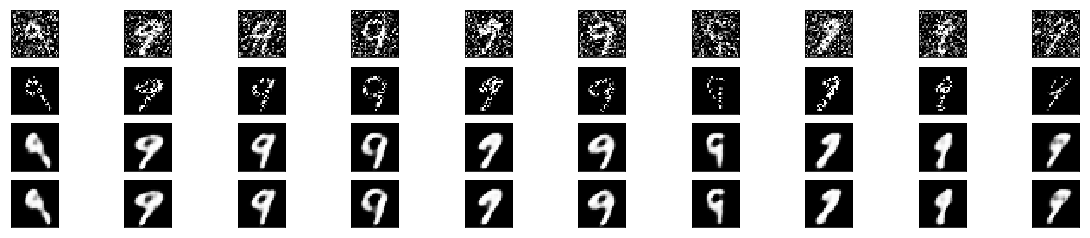

In [4]:
def show_imgs(x_test, decoded_imgs, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(4, n, i+1)
        plt.imshow(x_test[0][i].reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(4, n, i+1 +n)
        plt.imshow(x_test[1][i].reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(4, n, i+ 1 +2*n)
        plt.imshow(decoded_imgs[0][i].reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(4, n, i+ 1 +3*n)
        plt.imshow(decoded_imgs[1][i].reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    plt.show()
    
decoded_imgs = autoencoder.predict([x_test_noisy, x_test_mask])
show_imgs([x_test_noisy,x_test_mask], decoded_imgs)

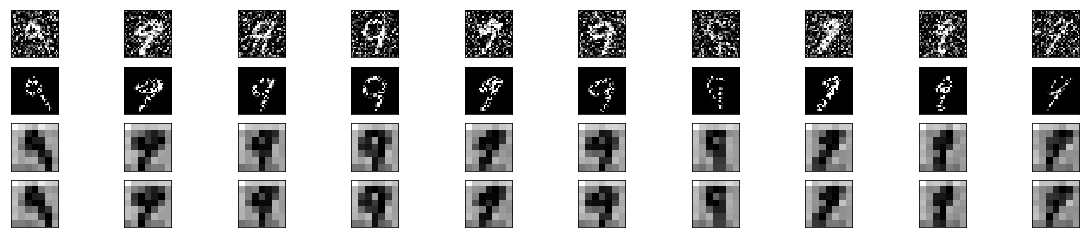

In [5]:
enbig1 = UpSampling2D(size=(2, 2))(encoded)
enbig2 = UpSampling2D(size=(2, 2))(enbig1)

autoencoder_show_hidden = Model([input1_img, input2_img], enbig2)
encoded_imgs = autoencoder_show_hidden.predict([x_test_noisy, x_test_mask])

show_imgs([x_test_noisy,x_test_mask], [encoded_imgs,encoded_imgs])


def show_hidden(x_test, encoded_imgs, n=10):
    
    en0=np.zeros((encoded_imgs.shape[0],encoded_imgs.shape[1],encoded_imgs.shape[2]))
    en1=np.zeros((encoded_imgs.shape[0],encoded_imgs.shape[1],encoded_imgs.shape[2]))
    en2=np.zeros((encoded_imgs.shape[0],encoded_imgs.shape[1],encoded_imgs.shape[2]))
    en3=np.zeros((encoded_imgs.shape[0],encoded_imgs.shape[1],encoded_imgs.shape[2]))

    for i in range(encoded_imgs.shape[0]):
        for j in range(encoded_imgs.shape[1]):
            for k in range(encoded_imgs.shape[2]):
                en0[i][j][k]=encoded_imgs[i][j][k][0]
                en1[i][j][k]=encoded_imgs[i][j][k][1]
                en2[i][j][k]=encoded_imgs[i][j][k][2]
                en3[i][j][k]=encoded_imgs[i][j][k][3]
    
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(5, n, i+1)
        plt.imshow(x_test[i].reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if decoded_imgs is not None:
            ax = plt.subplot(5, n, i+ 1 +n)
            plt.imshow(en0[i].reshape(28,28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
            ax = plt.subplot(5, n, i+ 1 +2*n)
            plt.imshow(en1[i].reshape(28,28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
            ax = plt.subplot(5, n, i+ 1 +3*n)
            plt.imshow(en2[i].reshape(28,28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
            ax = plt.subplot(5, n, i+ 1 +4*n)
            plt.imshow(en3[i].reshape(28,28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()

#show_hidden(x_test, encoded_imgs)

In [6]:
autoencoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
i2c1 (Conv2D)                   (None, 28, 28, 16)   160         input_6[0][0]                    
__________________________________________________________________________________________________
i1c1 (Conv2D)                   (None, 28, 28, 16)   160         input_5[0][0]                    
__________________________________________________________________________________________________
i2p1 (MaxP

In [7]:
input1_train2_autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 16)        0         
_________________________________________________________________
t2p1 (MaxPooling2D)          (None, 14, 14, 16)        0         
_________________________________________________________________
t2c1 (Conv2D)                (None, 14, 14, 8)         1160      
_________________________________________________________________
t2p2 (UpSampling2D)          (None, 28, 28, 8)         0         
_________________________________________________________________
t2d1 (Conv2D)                (None, 28, 28, 16)        1168      
Total params: 2,328
Trainable params: 2,328
Non-trainable params: 0
_________________________________________________________________
